In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum as spark_sum, collect_list, when, udf
from pyspark.sql.window import Window
from pyspark.sql.types import StringType
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import joblib

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("CustomerPurchaseAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/13 03:59:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load and preprocess data
df = pd.read_csv('/kaggle/input/customer-purchase-dataset/customer_purchase_dataset (1).csv', parse_dates=['order_date'])

In [4]:
# Convert to Spark DataFrame
spark_df = spark.createDataFrame(df)

In [5]:
# Define the window specification for customer-level calculations ordered by date
window_spec = Window.partitionBy("customer_id").orderBy("order_date")

In [6]:
# Number of previous purchases per customer (excluding current)
spark_df = spark_df.withColumn("prev_purchases", count("*").over(window_spec) - 1)

# Total spent before the current purchase (historical total)
spark_df = spark_df.withColumn(
    "total_spent_historical", 
    spark_sum("total_amount").over(window_spec.rowsBetween(Window.unboundedPreceding, -1))
)

In [7]:
# Average order value from previous purchases (avoid division by zero)
spark_df = spark_df.withColumn(
    "avg_order_value", 
    col("total_spent_historical") / when(col("prev_purchases") == 0, 1).otherwise(col("prev_purchases"))
)

# Collect list of past product categories for each customer
spark_df = spark_df.withColumn(
    "previous_categories", 
    collect_list("product_category").over(window_spec.rowsBetween(Window.unboundedPreceding, -1))
)

In [8]:
# Function to get mode (most frequent category)
def get_mode(categories):
    if not categories:
        return "Unknown"
    return Counter(categories).most_common(1)[0][0]

# Register UDF
mode_udf = udf(get_mode, StringType())

In [9]:
# Add preferred category column using UDF on previous categories
spark_df = spark_df.withColumn("preferred_category", mode_udf("previous_categories"))

In [10]:
# Compute 99th percentile to cap extreme total_amount values
total_amount_quantile = spark_df.approxQuantile("total_amount", [0.99], 0.05)[0]

# Cap total_amount values exceeding the 99th percentile
spark_df = spark_df.withColumn(
    "total_amount", 
    when(col("total_amount") > total_amount_quantile, total_amount_quantile).otherwise(col("total_amount"))
)

In [11]:
# Convert to Pandas DataFrame and drop temporary 'previous_categories' column
df = spark_df.toPandas().drop(columns=['previous_categories'])
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,customer_id,order_date,total_amount,product_category,payment_type,delivery_location,days_since_last_purchase,repeat_purchase_next_30_days,prev_purchases,total_spent_historical,avg_order_value,preferred_category
0,1,2023-02-05,49156.35,Home Appliances,Cash,Biratnagar,34,1,0,NaN,NaN,Unknown
1,1,2023-02-19,19603.89,Stationery,Credit Card,Pokhara,126,1,1,49156.35,49156.35,Home Appliances
2,1,2023-05-02,1687.35,Electronics,Credit Card,Biratnagar,106,1,2,68760.24,34380.12,Home Appliances
3,1,2023-08-07,24101.93,Groceries,Credit Card,Biratnagar,174,1,3,70447.59,23482.53,Home Appliances
4,2,2024-03-13,4837.60,Home Appliances,Digital Wallet,Lalitpur,24,0,0,NaN,NaN,Unknown


In [12]:
# Data preparation
X = df.drop(['repeat_purchase_next_30_days', 'customer_id', 'order_date'], axis=1)
y = df['repeat_purchase_next_30_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
numerical_features = ['total_amount', 'days_since_last_purchase', 'prev_purchases', 'avg_order_value']
categorical_features = ['product_category', 'payment_type', 'delivery_location', 'preferred_category']

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

In [15]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    cv_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    test_f1 = f1_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"{name} CV F1: {cv_f1:.4f}")
    print(f"{name} Test F1: {test_f1:.4f}")
    print(f"{name} Test AUC: {test_auc:.4f}")
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion matrix plot
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} AUC = {test_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.show()
    
    # Feature importance for Random Forest and XGBoost
    if name in ["Random Forest", "XGBoost"]:
        importances = model.named_steps['classifier'].feature_importances_
        feature_names = numerical_features + list(model.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', figsize=(10, 6), title=f'Feature Importance - {name}')
        plt.show()
    
    return model, cv_f1


In [16]:
# Models
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))])
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(random_state=42, eval_metric='auc'))])

models = [
    (lr_pipeline, "Logistic Regression"),
    (rf_pipeline, "Random Forest"),
    (xgb_pipeline, "XGBoost")
]

Logistic Regression CV F1: 0.4517
Logistic Regression Test F1: 0.4873
Logistic Regression Test AUC: 0.5075
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.54      0.50        94
           1       0.53      0.45      0.49       106

    accuracy                           0.49       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.50      0.49      0.49       200



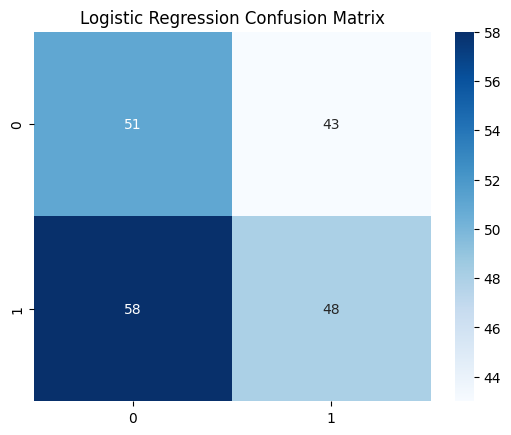

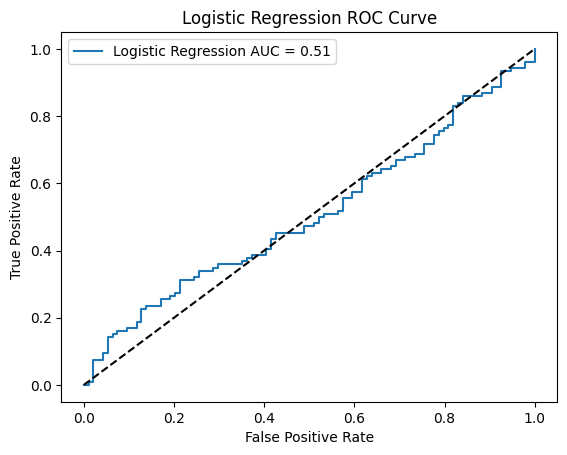

Random Forest CV F1: 0.5488
Random Forest Test F1: 0.5545
Random Forest Test AUC: 0.5063
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.44      0.46        94
           1       0.54      0.58      0.55       106

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200



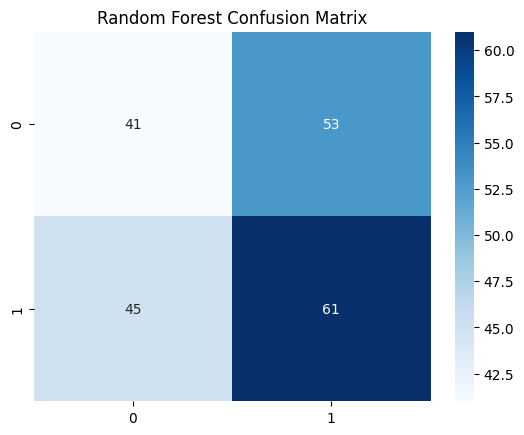

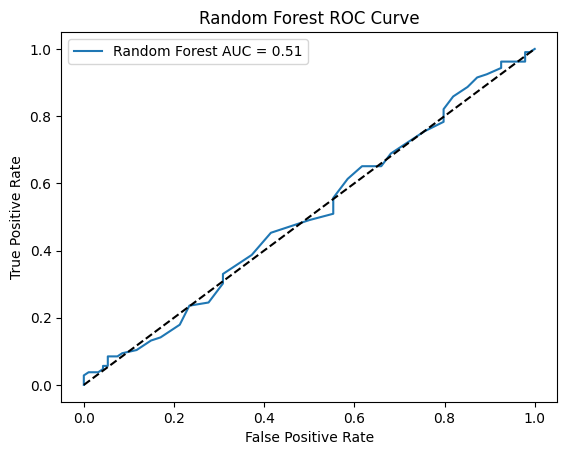

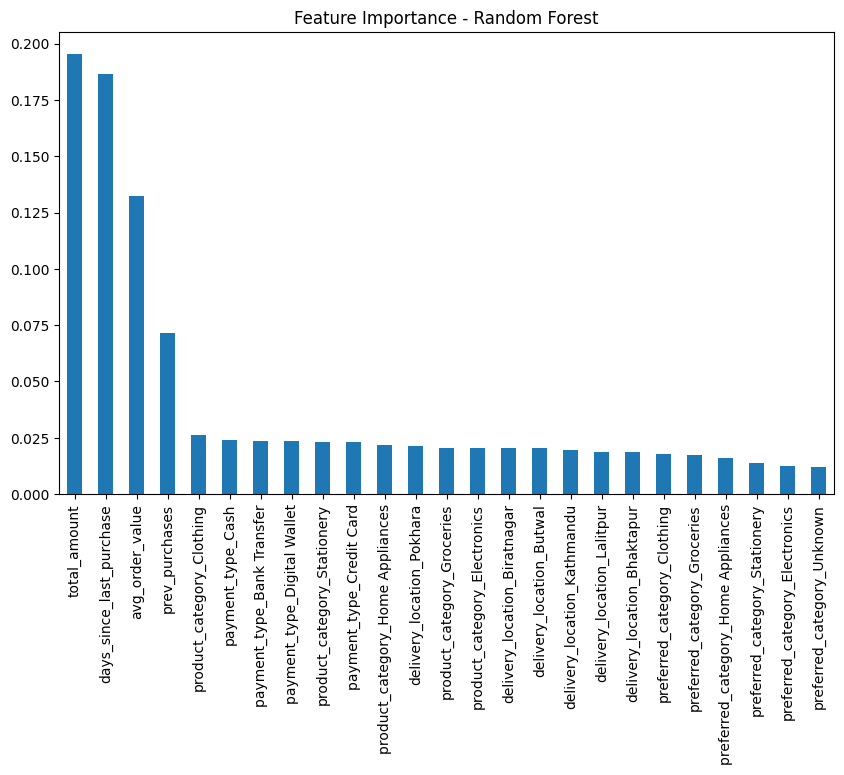

XGBoost CV F1: 0.5308
XGBoost Test F1: 0.5753
XGBoost Test AUC: 0.5400
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.47      0.49        94
           1       0.56      0.59      0.58       106

    accuracy                           0.54       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.54      0.53       200



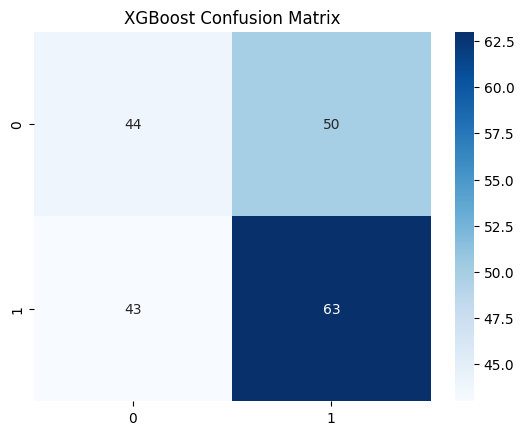

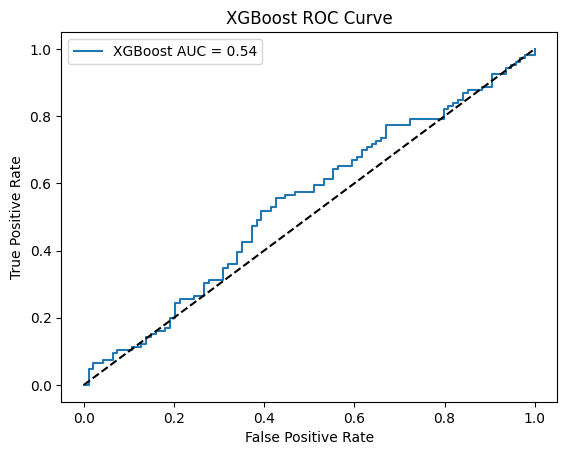

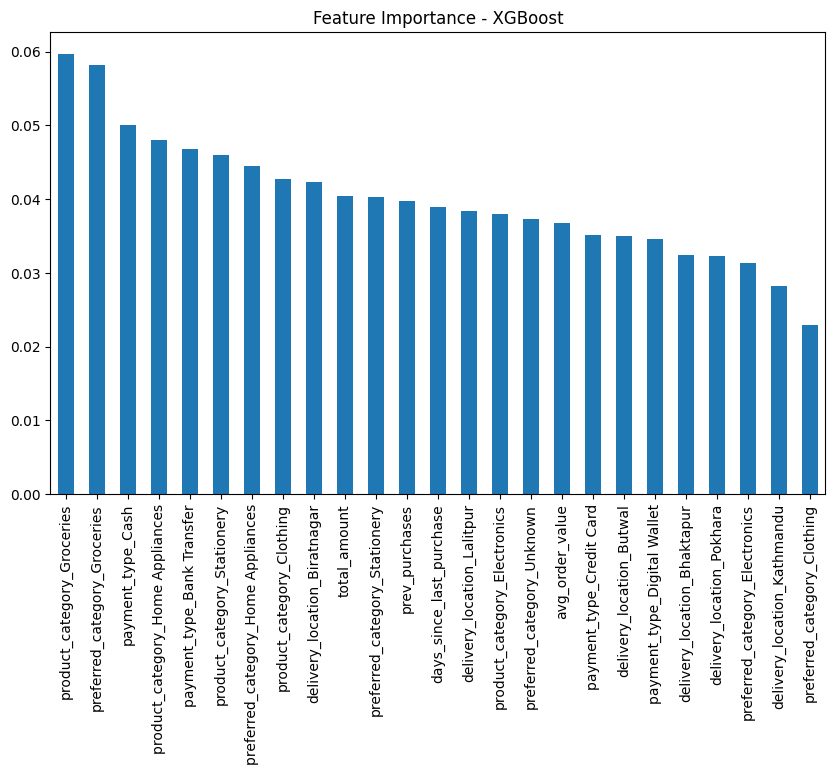

In [17]:
best_model = None
best_f1 = 0
best_name = ""

for pipeline, name in models:
    trained_model, cv_f1 = evaluate_model(pipeline, name)
    if cv_f1 > best_f1:
        best_f1 = cv_f1
        best_model = trained_model
        best_name = name

In [18]:
# Save best model
joblib.dump(best_model, 'best_model.pkl')

print(f"Best Model: {best_name} with CV F1: {best_f1:.4f}")

Best Model: Random Forest with CV F1: 0.5488


In [19]:
# Inference Example
sample_input = pd.DataFrame([{
    "total_amount": 37206.75,
    "product_category": "Groceries",
    "payment_type": "Credit Card",
    "delivery_location": "Lalitpur",
    "days_since_last_purchase": 26,
    "prev_purchases": 0,
    "total_spent_historical": 0,
    "avg_order_value": 37206.75,
    "preferred_category": "Groceries"
}])

In [20]:
prediction = best_model.predict(sample_input)
prediction_proba = best_model.predict_proba(sample_input)
print("Inference Example")
print("Sample Input:")
print(sample_input)
print("\nPredicted Class:", "Repeat Purchase" if int(prediction[0]) == 1 else "No Repeat Purchase")
print(f"Prediction Probability (No Repeat | Repeat): {prediction_proba[0][0]:.2f} | {prediction_proba[0][1]:.2f}")

Inference Example
Sample Input:
   total_amount product_category payment_type delivery_location  \
0      37206.75        Groceries  Credit Card          Lalitpur   

   days_since_last_purchase  prev_purchases  total_spent_historical  \
0                        26               0                       0   

   avg_order_value preferred_category  
0         37206.75          Groceries  

Predicted Class: No Repeat Purchase
Prediction Probability (No Repeat | Repeat): 0.66 | 0.34
